# Car Insurance Claim Prediction Model
I have recently been in the market for buying my first car and I've been interested in car insurance. From the types of policies, car safety, calculatable factors, and more. Thus, I have decided to build a model that will predict which policy owners will submit a claim within 6 months and how many claims will be made in that time period using data from kaggle. - Jion Kim

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
import graphviz # tree visualization
import pydotplus # tree visualization
import os
from scipy.stats import chi2_contingency

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

     
train_set = pd.read_csv("train.csv")
true_test_set = pd.read_csv("test.csv")


## Pre-processing

Let's look into what "features" we can base our model on:

In [2]:
train_set = train_set.set_index("policy_id")
true_test_set = true_test_set.set_index("policy_id")
print("Data shape:",train_set.shape)
train_set.head()

Data shape: (58592, 43)


,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
policy_id,,,,,,,,,,,,,,,,,,,,,
ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


We see that we have 44 possible columns that we can use to build our model off of, but I doubt all of them are relevant (i.e. policy_id)

In [3]:
train_set['is_claim'].value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

Let's check for high cardinality "object" features to see if we can weed out any unneccesary features.

In [4]:
objects = train_set.select_dtypes("object").nunique()
objects

area_cluster                        22
segment                              6
model                               11
fuel_type                            3
max_torque                           9
max_power                            9
engine_type                         11
is_esc                               2
is_adjustable_steering               2
is_tpms                              2
is_parking_sensors                   2
is_parking_camera                    2
rear_brakes_type                     2
transmission_type                    2
steering_type                        3
is_front_fog_lights                  2
is_rear_window_wiper                 2
is_rear_window_washer                2
is_rear_window_defogger              2
is_brake_assist                      2
is_power_door_locks                  2
is_central_locking                   2
is_power_steering                    2
is_driver_seat_height_adjustable     2
is_day_night_rear_view_mirror        2
is_ecw                   

It seems like area_cluster, model, and engine type seem to be high cardinality features but they seem pretty important. Let's keep them.

Additionally, we can see that there are there are many features that use binary classification. Let's see if these are able to give us any insight into whether or not we should keep them.

In [5]:
features_for_use = []
object_features_for_use = []
for value_i in range(len(objects)):
    if objects[value_i] == 2:
        index_i = objects.index[value_i]
        Crosstab=pd.crosstab(index=train_set[index_i],columns=train_set['is_claim'])
        print(Crosstab)
        p_val = chi2_contingency(Crosstab)[1]
        print("p-value:",p_val)
        print("Verdict: probably not related") if p_val > 0.05 else print("Verdict: maybe related")
        if p_val <= 0.05:
            features_for_use.append(index_i)
            object_features_for_use.append(index_i)
            train_set[index_i] = train_set[index_i].map({'Yes': 1, 'No': 0})
        print()

is_claim      0     1
is_esc               
No        37640  2551
Yes       17204  1197
p-value: 0.47973082296004166
Verdict: probably not related

is_claim                    0     1
is_adjustable_steering             
No                      21688  1378
Yes                     33156  2370
p-value: 0.0008041954126638532
Verdict: maybe related

is_claim      0     1
is_tpms              
No        41727  2847
Yes       13117   901
p-value: 0.8804734284234931
Verdict: probably not related

is_claim                0     1
is_parking_sensors             
No                   2245   128
Yes                 52599  3620
p-value: 0.046026600078480424
Verdict: maybe related

is_claim               0     1
is_parking_camera             
No                 33414  2290
Yes                21430  1458
p-value: 0.8464941782641769
Verdict: probably not related

is_claim              0     1
rear_brakes_type             
Disc              13117   901
Drum              41727  2847
p-value: 0.8804734284

In [6]:
features_for_use

['is_adjustable_steering',
 'is_parking_sensors',
 'is_front_fog_lights',
 'is_brake_assist',
 'is_driver_seat_height_adjustable']

<AxesSubplot: >

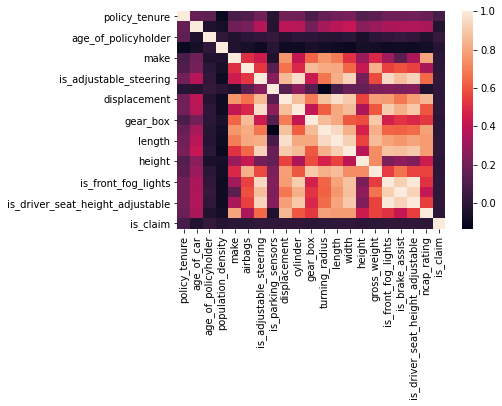

In [7]:
sns.heatmap(train_set.select_dtypes("number").corr())

No complaints here, so we can add them except for is_claim to the features_for_use training set.

In [8]:
numerical = train_set.select_dtypes("number").drop('is_claim', axis=1).nunique()
for value_i in range(len(numerical)):
    features_for_use.append(numerical.index[value_i])

features_for_use

['is_adjustable_steering',
 'is_parking_sensors',
 'is_front_fog_lights',
 'is_brake_assist',
 'is_driver_seat_height_adjustable',
 'policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'population_density',
 'make',
 'airbags',
 'is_adjustable_steering',
 'is_parking_sensors',
 'displacement',
 'cylinder',
 'gear_box',
 'turning_radius',
 'length',
 'width',
 'height',
 'gross_weight',
 'is_front_fog_lights',
 'is_brake_assist',
 'is_driver_seat_height_adjustable',
 'ncap_rating']

In [9]:
cleaned_train_set = train_set[features_for_use]
cleaned_train_set.head()

,is_adjustable_steering,is_parking_sensors,is_front_fog_lights,is_brake_assist,is_driver_seat_height_adjustable,policy_tenure,age_of_car,age_of_policyholder,population_density,make,...,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_brake_assist,is_driver_seat_height_adjustable,ncap_rating
policy_id,,,,,,,,,,,,,,,,,,,,,
ID00001,0,1,0,0,0,0.515874,0.05,0.644231,4990,1,...,5,4.6,3445,1515,1475,1185,0,0,0,0
ID00002,0,1,0,0,0,0.672619,0.02,0.375000,27003,1,...,5,4.6,3445,1515,1475,1185,0,0,0,0
ID00003,0,1,0,0,0,0.841110,0.02,0.384615,4076,1,...,5,4.6,3445,1515,1475,1185,0,0,0,0
ID00004,1,1,1,1,1,0.900277,0.11,0.432692,21622,1,...,5,4.8,3995,1735,1515,1335,1,1,1,2
ID00005,0,0,0,0,0,0.596403,0.11,0.634615,34738,2,...,5,5.0,3731,1579,1490,1155,0,0,0,2


In [10]:
y = train_set['is_claim']
y

policy_id
ID00001    0
ID00002    0
ID00003    0
ID00004    0
ID00005    0
          ..
ID58588    0
ID58589    0
ID58590    0
ID58591    0
ID58592    0
Name: is_claim, Length: 58592, dtype: int64

Data Standardization give data zero mean and unit variance

In [11]:
x = preprocessing.StandardScaler().fit_transform(cleaned_train_set)
x,X, y, Y = train_test_split(x,y, test_size=0.3, random_state=1)

# Decision Tree Modeling and Eval

In [12]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(x, y)
y_pred=clf_tree.predict(X)
trainScores={}
trainScores['Tree-accuracy']=accuracy_score(Y, y_pred)
trainScores['Tree-f1-score']=f1_score(Y, y_pred, average='weighted') 

'''
built accuracy function just for fun
count = 0
for i in range(len(y_pred)):
    if y_pred[i] == Y[i]:
        count += 1
print(count, "/", y_pred, "or", count/len(y_pred))
'''


'\nbuilt accuracy function just for fun\ncount = 0\nfor i in range(len(y_pred)):\n    if y_pred[i] == Y[i]:\n        count += 1\nprint(count, "/", y_pred, "or", count/len(y_pred))\n'

In [13]:
'''
dot_data = tree.export_graphviz(clf_tree, out_file=None, 
                     feature_names=features_for_use,  
                     class_names='is_claim',  
                     filled=True, rounded=True,  
                     special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"8,8!"')
gvz_graph = graphviz.Source(graph.to_string())

gvz_graph 
'''
trainScores

{'Tree-accuracy': 0.8683581749914666, 'Tree-f1-score': 0.874723847269271}

Not a bad score if you ask me, let's try another model

In [14]:
clf_log = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf_log.fit(x, y)

y_pred=clf_log.predict(X)
y_proba=clf_log.predict_proba(X)

trainScores['LogReg-accuracy']=accuracy_score(Y, y_pred)
trainScores['LogReg-f1-score']=f1_score(Y, y_pred, average='weighted') 
print(y_pred)
print(trainScores)

[0 0 0 ... 0 0 0]
{'Tree-accuracy': 0.8683581749914666, 'Tree-f1-score': 0.874723847269271, 'LogReg-accuracy': 0.9367391057003072, 'LogReg-f1-score': 0.906141823197113}


The Logistic Reggression did better overall! We should use it for our real prediction!

# Prediction on real test set based on Model

In [15]:
for col_name in object_features_for_use:
    true_test_set[col_name] = true_test_set[col_name].map({'Yes': 1, 'No': 0})
cleaned_test_set = true_test_set[features_for_use] 
cleaned_test_set

,is_adjustable_steering,is_parking_sensors,is_front_fog_lights,is_brake_assist,is_driver_seat_height_adjustable,policy_tenure,age_of_car,age_of_policyholder,population_density,make,...,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_brake_assist,is_driver_seat_height_adjustable,ncap_rating
policy_id,,,,,,,,,,,,,,,,,,,,,
ID58593,0,1,0,0,0,0.341732,0.00,0.586538,4076,1,...,5,4.60,3445,1515,1475,1185,0,0,0,0
ID58594,1,1,1,1,1,0.307241,0.13,0.442308,8794,1,...,5,4.80,3845,1735,1530,1335,1,1,1,2
ID58595,0,0,0,0,0,0.327924,0.12,0.451923,8794,2,...,5,5.00,3731,1579,1490,1155,0,0,0,2
ID58596,0,1,0,0,0,0.782654,0.01,0.461538,34738,1,...,5,4.60,3445,1515,1475,1185,0,0,0,0
ID58597,0,1,0,0,0,1.233404,0.02,0.634615,34738,1,...,5,4.60,3445,1515,1475,1185,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID97651,1,1,1,1,1,0.047982,0.15,0.740385,27003,1,...,5,4.80,3845,1735,1530,1335,1,1,1,2
ID97652,1,1,1,1,1,1.224838,0.05,0.509615,8794,3,...,6,5.20,4300,1790,1635,1720,1,1,1,3
ID97653,1,1,1,1,1,0.520287,0.12,0.355769,13051,1,...,5,4.85,3990,1745,1500,1410,1,1,1,0


In [16]:
testScores={}
X = preprocessing.StandardScaler().fit_transform(cleaned_test_set)

y_pred=clf_log.predict(X)
y_proba=clf_log.predict_proba(X)

y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
trainScores

{'Tree-accuracy': 0.8683581749914666,
 'Tree-f1-score': 0.874723847269271,
 'LogReg-accuracy': 0.9367391057003072,
 'LogReg-f1-score': 0.906141823197113}

# So how many claims are made?

Let's try the Logistic Regression first:

In [18]:
claim_count = 0
for claim in y_pred:
    if claim:
        claim_count += 1
print(claim_count, "claims made or", claim_count, "claims out of", len(y_pred), "or", claim_count/len(y_pred))

0 claims made or 0 claims out of 39063 or 0.0


That doesn't seem right. This is probably due to the Logistic Regression Model being overfit. Let's try the decision tree

In [19]:
y_pred=clf_tree.predict(X)
claim_count = 0
for claim in y_pred:
    if claim:
        claim_count += 1
print(claim_count, "claims made or", claim_count, "claims out of", len(y_pred), "or", claim_count/len(y_pred))

3098 claims made or 3098 claims out of 39063 or 0.0793077848603538


This makes more sense and should be fairly accurate.

We should predict that 3,096 claims are made and we can be about 87% sure about that.

Now let's look at which policy ids are predicted to submit a claim in 6 months.

In [20]:
claim_policy_ids = []

for i in range(len(y_pred)):
    if y_pred[i]:
        claim_policy_ids.append(true_test_set.index[i])
print(claim_policy_ids)

['ID58599', 'ID58612', 'ID58620', 'ID58641', 'ID58656', 'ID58666', 'ID58720', 'ID58724', 'ID58726', 'ID58735', 'ID58739', 'ID58740', 'ID58763', 'ID58770', 'ID58785', 'ID58794', 'ID58795', 'ID58799', 'ID58801', 'ID58822', 'ID58826', 'ID58831', 'ID58839', 'ID58840', 'ID58853', 'ID58856', 'ID58862', 'ID58889', 'ID58895', 'ID58896', 'ID58902', 'ID58928', 'ID58934', 'ID58948', 'ID58951', 'ID58962', 'ID58980', 'ID58987', 'ID58991', 'ID59001', 'ID59003', 'ID59005', 'ID59015', 'ID59026', 'ID59031', 'ID59032', 'ID59043', 'ID59055', 'ID59062', 'ID59076', 'ID59094', 'ID59098', 'ID59100', 'ID59114', 'ID59120', 'ID59123', 'ID59138', 'ID59144', 'ID59147', 'ID59187', 'ID59228', 'ID59247', 'ID59262', 'ID59274', 'ID59292', 'ID59300', 'ID59314', 'ID59334', 'ID59359', 'ID59369', 'ID59389', 'ID59390', 'ID59403', 'ID59406', 'ID59441', 'ID59442', 'ID59444', 'ID59452', 'ID59453', 'ID59467', 'ID59485', 'ID59501', 'ID59502', 'ID59510', 'ID59518', 'ID59524', 'ID59542', 'ID59565', 'ID59567', 'ID59569', 'ID59584'

Here are all the policy ids that are predicted to submit a claim in the next 6 months!

Next steps: We can look into why the logistic regression model predicted that 0 claims would be made in 6 months. We can also look into what kind of cars/drivers are predicted to be submitting claims.